# Multivariate Anomaly Detection
- statistical method for short amount of batch size
- compare Mahalanobis against Mean Absolute Error method

## How Mahalanobis works
- First find the mean value from all features
- check the spread of each data
- check the relationships among features
- measure distance from its average with extra weights based on its spread and relationships.

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt

In [10]:
# Fake data
# 1 day = 12 records, 2 days = 24 records
date_range = pd.date_range(start='2025-02-27', periods=24, freq='5min')
df = pd.DataFrame({
    'sensor1': np.random.normal(100, 10, 24),
    'sensor2': np.random.normal(50, 5, 24),
    'sensor3': np.random.normal(75, 15, 24)
}, index=date_range)
df.head(3)

,sensor1,sensor2,sensor3
2025-02-27 00:00:00,113.333140,48.204391,84.221239
2025-02-27 00:05:00,115.010746,44.891837,61.342920
2025-02-27 00:10:00,83.003696,55.467846,76.268368


<Axes: >

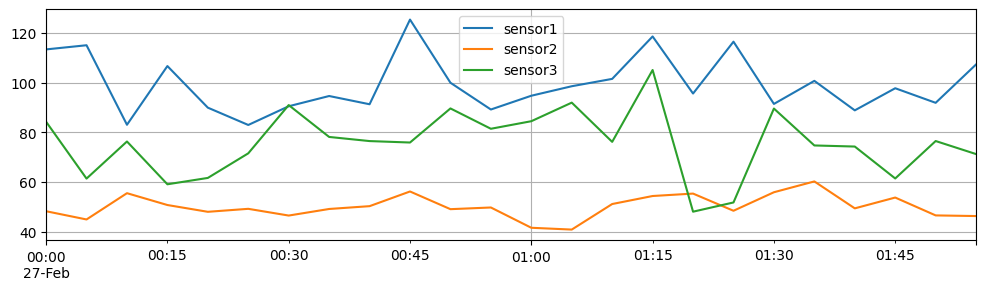

In [11]:
df.plot(grid=True, figsize=(12,3))

<Axes: >

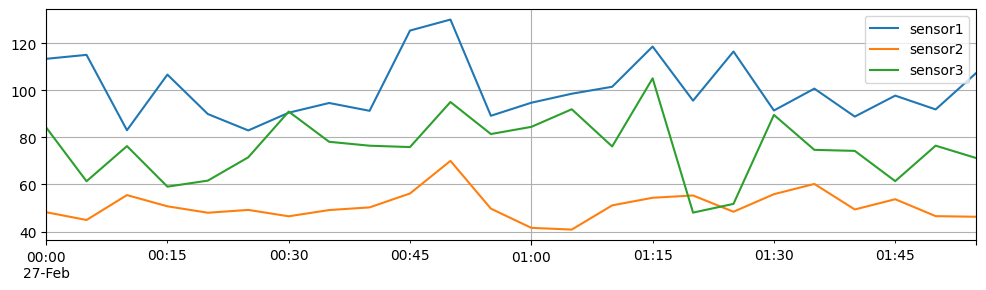

In [12]:
# Inject an anomaly
df.iloc[10, :] = [130, 70, 95]  # Outlier across all sensors
df.plot(grid=True, figsize=(12,3))

In [15]:
# Calculate mean and covariance matrix
mean = df.mean()
cov = df.cov()
inv_cov = np.linalg.inv(cov)

# Compute Mahalanobis Distance for each point
def mahalanobis_dist(row, mean, inv_cov):
    diff = row - mean
    return mahalanobis(row, mean, inv_cov)

mahalanobis_distances = df.apply(lambda row: mahalanobis_dist(row, mean, inv_cov), axis=1)

# Set a threshold (e.g., 95th percentile or domain-specific)
threshold = np.percentile(mahal_distances, 95)  # Top 5% as anomalies
df['anomaly'] = mahalanobis_distances > threshold

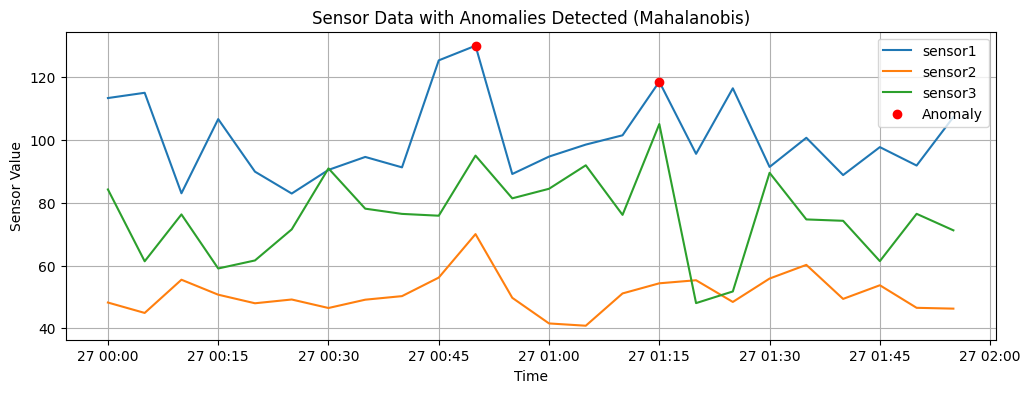

In [19]:
# Visualize
plt.figure(figsize=(12, 4))
for col in df.columns[:-1]:  # Exclude 'anomaly'
    plt.plot(df.index, df[col], label=col)
plt.scatter(df.index[df['anomaly']], 
            df[df['anomaly']]['sensor1'], 
            color='red', label='Anomaly', zorder=5)
plt.legend(); plt.grid()
plt.title('Sensor Data with Anomalies Detected (Mahalanobis)')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.show()

In [20]:
# Print anomalies
anomalies = df[df['anomaly']]
print(f"Number of anomalies detected: {len(anomalies)}")
print("Anomalies:\n", anomalies)

Number of anomalies detected: 2
Anomalies:
                         sensor1    sensor2     sensor3  anomaly
2025-02-27 00:50:00  130.000000  70.000000   95.000000     True
2025-02-27 01:15:00  118.548261  54.330066  105.044383     True


# MAE method

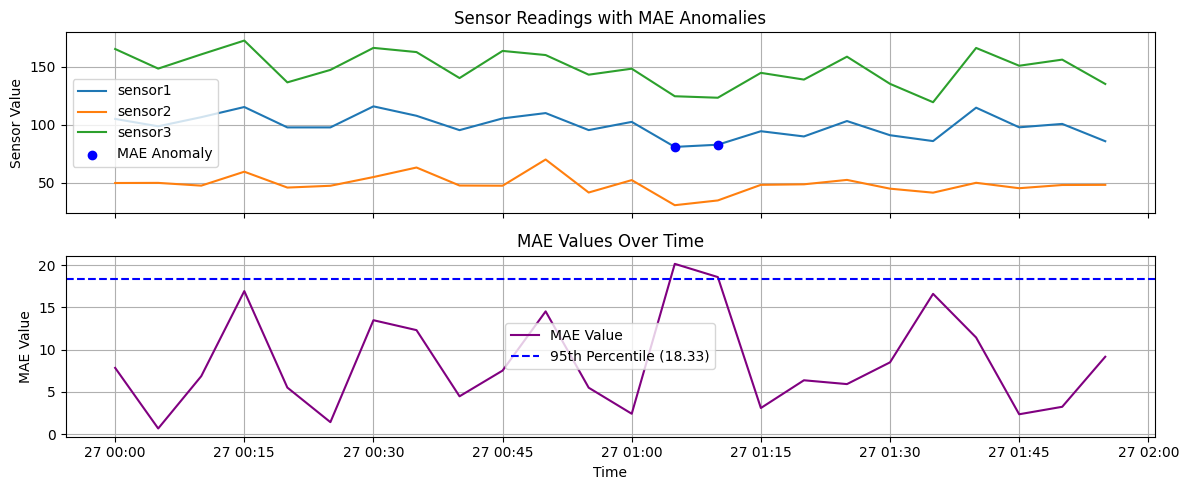

MAE Anomalies:
                        sensor1    sensor2     sensor3  mae_value
2025-02-27 01:05:00  80.867198  30.635248  124.512057  20.143995
2025-02-27 01:10:00  82.750822  34.734481  123.224549  18.578879


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create date range with 5-minute intervals for 24 records (2 hours)
date_range = pd.date_range(start='2025-02-27', periods=24, freq='5min')

# Simulate sample data with correlated sensors
np.random.seed(42)
sensor1 = np.random.normal(100, 10, 24)
sensor2 = sensor1 * 0.5 + np.random.normal(0, 5, 24)  # Correlated with sensor1
np.random.seed(14)
sensor3 = sensor1 * 1.5 + np.random.normal(0, 5, 24)  # Correlated with sensor1
df = pd.DataFrame({
    'sensor1': sensor1,
    'sensor2': sensor2,
    'sensor3': sensor3
}, index=date_range)

# Inject an anomaly: unusual combination but within individual ranges
df.iloc[10] = [110, 70, 160]  # Adjusted to include sensor3 (e.g., sensor3 = 1.5 * sensor1 approx)

# --- MAE-based Anomaly Detection ---
# Use mean as "predicted" value, compute absolute deviations
mae_per_sensor = df.apply(lambda x: np.abs(x - x.mean()))
mae_combined = mae_per_sensor.mean(axis=1)  # Average MAE across sensors
mae_threshold = np.percentile(mae_combined, 95)  # Top 5% as anomalies
df['mae_value'] = mae_combined  # Store MAE values for plotting
df['mae_anomaly'] = mae_combined > mae_threshold

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)  # Increased height for clarity

# Plot Sensor Data with MAE Anomalies
for col in ['sensor1', 'sensor2', 'sensor3']:
    ax1.plot(df.index, df[col], label=col)
ax1.scatter(df.index[df['mae_anomaly']], 
            df[df['mae_anomaly']]['sensor1'], 
            color='blue', label='MAE Anomaly', zorder=5)
ax1.set_title('Sensor Readings with MAE Anomalies')
ax1.set_ylabel('Sensor Value')
ax1.grid()
ax1.legend()

# Plot MAE Values
ax2.plot(df.index, df['mae_value'], color='purple', label='MAE Value')
ax2.axhline(y=mae_threshold, color='blue', linestyle='--', label=f'95th Percentile ({mae_threshold:.2f})')
ax2.set_title('MAE Values Over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('MAE Value')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

# Print results
print("MAE Anomalies:\n", df[df['mae_anomaly']][['sensor1', 'sensor2', 'sensor3', 'mae_value']])
# print("\nAll MAE Values:\n", df[['sensor1', 'sensor2', 'sensor3', 'mae_value']])

# Mahalanobis method

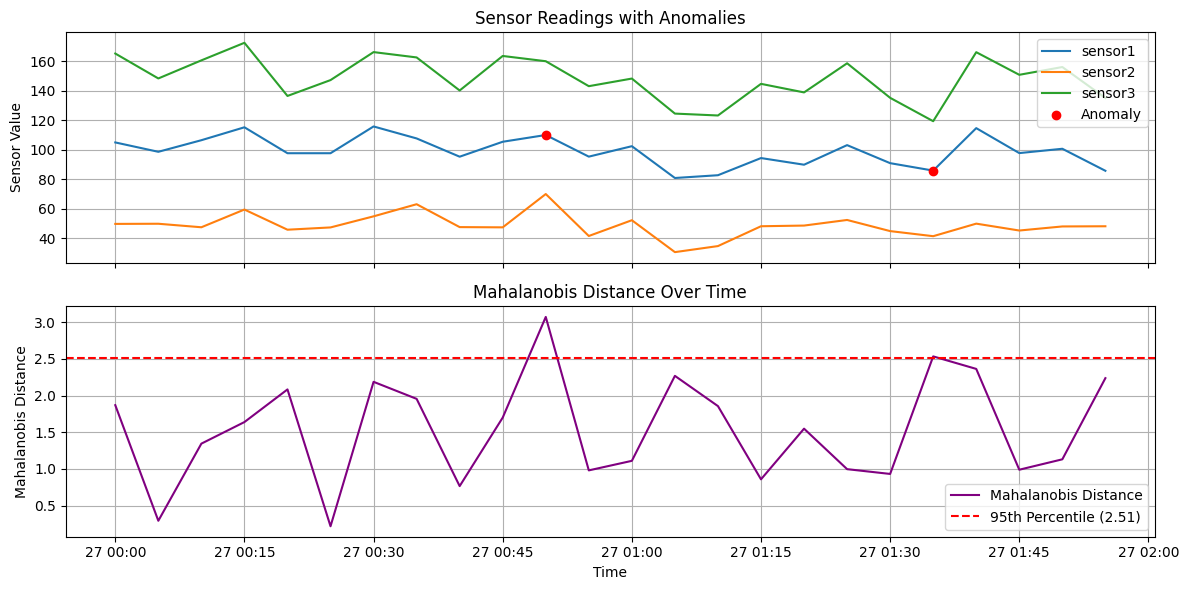

Anomalies:
                         sensor1    sensor2  mahal_distance
2025-02-27 00:50:00  110.000000  70.000000        3.070528
2025-02-27 01:35:00   85.876963  41.432963        2.532967


In [45]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt

# Create date range with 5-minute intervals for 24 records (2 hours)
date_range = pd.date_range(start='2025-02-27', periods=24, freq='5min')

# Simulate sample data with correlated sensors
np.random.seed(42)
sensor1 = np.random.normal(100, 10, 24)
sensor2 = sensor1 * 0.5 + np.random.normal(0, 5, 24)  # Correlated with sensor1
np.random.seed(14)
sensor3 = sensor1 * 1.5 + np.random.normal(0, 5, 24)  # Correlated with sensor1
df = pd.DataFrame({
    'sensor1': sensor1,
    'sensor2': sensor2,
    'sensor3': sensor3
}, index=date_range)

# Inject an anomaly: unusual combination but within individual ranges
df.iloc[10] = [110, 70, 160]  # Adjusted to include sensor3 (e.g., sensor3 = 1.5 * sensor1 approx)

# --- Mahalanobis Distance ---
mean = df.mean()
cov = df.cov()
inv_cov = np.linalg.inv(cov)

# Compute Mahalanobis Distance for each point
mahal_distances = df.apply(lambda row: mahalanobis(row, mean, inv_cov), axis=1)
df['mahal_distance'] = mahal_distances

# Define anomalies based on a threshold (95th percentile)
threshold = np.percentile(mahal_distances, 95)
df['anomaly'] = mahal_distances > threshold

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot Sensor Data with Anomalies
for col in ['sensor1', 'sensor2', 'sensor3']:
    ax1.plot(df.index, df[col], label=col)
ax1.scatter(df.index[df['anomaly']], 
            df[df['anomaly']]['sensor1'], 
            color='red', label='Anomaly', zorder=5)
ax1.set_title('Sensor Readings with Anomalies')
ax1.set_ylabel('Sensor Value')
ax1.grid()
ax1.legend()

# Plot Mahalanobis Distance
ax2.plot(df.index, df['mahal_distance'], color='purple', label='Mahalanobis Distance')
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'95th Percentile ({threshold:.2f})')
ax2.set_title('Mahalanobis Distance Over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Mahalanobis Distance')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

# Print anomalies and Mahalanobis Distances
print("Anomalies:\n", df[df['anomaly']][['sensor1', 'sensor2', 'mahal_distance']])
# print("\nAll Mahalanobis Distances:\n", df[['sensor1', 'sensor2', 'mahal_distance']])

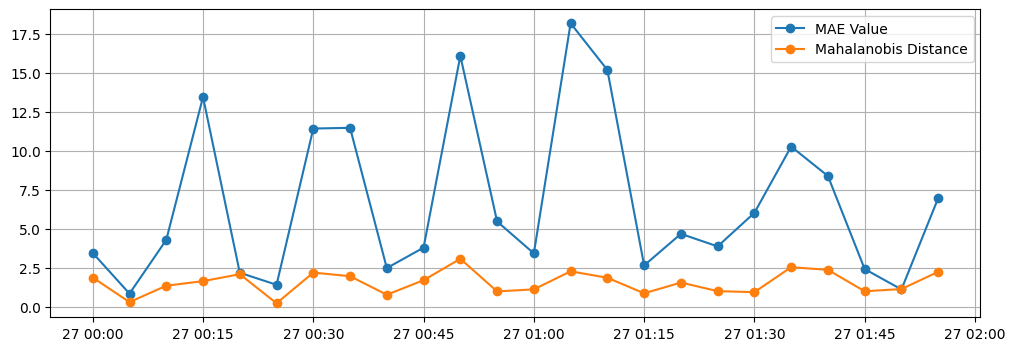

In [46]:
plt.figure(figsize=(12,4))
plt.plot(mae_values, "-o", label='MAE Value')
plt.plot(df.index, df['mahal_distance'],  "-o",  label='Mahalanobis Distance')
plt.grid()
plt.legend()
plt.show()